# It's a bird. It's a plane. It's SUPER... GAN!


## Abstract

This tutorial will detail the creation, development and training of both a CNN and a GAN. It includes pre-processing the data, the selection process of our loss functions and optimisers, and the training loops of each. After proving that the generated CNN is sufficiently equipped for binary image classification using bird and plane datasets, we will utilise that same structure for part of our GAN. The tutorial will also go over the performance of our networks by measuring the accuracy of our CNN and presenting bird images that the GAN has attempted to create.

## Table of Contents

1. [Learning Objectives](#Learning-Objectives)
2. [Distinctive Features](#Disctinctive-Features)
3. [Understanding the CIFAR-10 Dataset](#Understanding-the-CIFAR-10-Dataset)
4. [Importing Required Libraries](#Importing-Required-Libraries)
5. [Data Pre-processing](#Data-Pre-processing)
6. [Data Visualisation](#Data-Visualisation)
7. [Define the Model in PyTorch: CNN Architecture](#Define-the-Model-in-PyTorch:-CNN-Architecture)
8. [Define a Loss Function and Optimiser](#Define-a-Loss-Function-and-Optimiser)
9. [Train the Model using the Training Set](#Train-the-Model-using-the-Training-Set)
10. [Hyperparameter Tuning](#Hyperparameter-Tuning)
11. [Model Evaluation & Visualising Results](#Model-Evaluation-&-Visualising-Results)
12. [Optimising the Model](#Optimising-the-Model)
13. [Conclusion](#Conclusion)
14. [References](#References)

## Learning Objectives

- Familiiarize ourself with the CIFAR-10 dataset, and its application to image classifcation models
- Understand the importance of data preprocessing and how to perform it
- Learn how to define a CNN model suitable for image classification tasks, while understanding the structure and importance of different layers
- Learn how to implement the training of a CNN model, including the forward pass, loss computation, backpropagation and parameter updates.
- Learn how to analyse and visualise the models performance using matplotlib 
- Learn to identify common issues that may arise during the training of our model, such as over/underfitting and how to prevent them

## Distinctive Features

In this project, I wanted to go over the complex features of a GAN, but didn't want to throw users into the deep end with an overwhelming amount of information to learn at once. 
As such, I tried to go for a gradual buildup, where we start off small with the data handling, and building a simple CNN model, before ramping up the intensity to a better, more involved model, and finally utilising this structure in a subsequent GAN.
In terms of other projects online, I think the benefit here is a shallower learning curve, allowing readers to 'dip their toes' first before going into the deep end which cover it well, but can be overwhelming [SOURCE: https://realpython.com/generative-adversarial-networks/].
This does however, lead to certain cons, specifically in that squeezing all this content in means that it is rather surface level compared to some tutorials that stick to their own field, such as [SOURCE: https://livebook.manning.com/book/deep-learning-with-pytorch/chapter-7/v-13/166] where there is a more comprehensive information each section.

## Understanding the CIFAR-10 Dataset

**Dataset:** https://www.cs.toronto.edu/~kriz/cifar.html<br>


The CIFAR-10 dataset consists of 60000 32x32 colour images, with 6000 images per class. It is split into training and testing sets with a 5:1 ratio, giving us 5000 and 1000 images in the training and test set respectively which is more than enough to train on. The images are howver, only 32x32 big which makes the dataset managable for training models with limited computation, but can present challenges as our lack of detail may make it harder for models to distinguish between our planes and birds.

## Importing required libraries

PyTorch for building and training the neural network.

In [1]:
import torch

If you have a CUDA enabled GPU, and install the CUDA toolkit you may be able to utilise it for faster training times by defining it as your device and offloading work to it later. It is worth considering that this may not always speed things up, if the cost of offloading the data is more than the time saved by the GPU utilisation.

In [2]:
print(torch.cuda.is_available())


if(torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True


Torchvision

In [3]:
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import utils
from torch.utils.data import Subset, DataLoader

Numpy for data manipulation and preprocessing

In [4]:
import numpy as np

Matplotlib for data visualisation

In [5]:
import matplotlib.pyplot as plt

Time for the monitoring of runtimes

In [6]:
import time

## Data Pre-processing

### Loading and transforming the data

First we can define a transform for the image data we are about to import, turning them into tensors. This turns the image into an understandable input for our model, while they also provide the benefit of supporting GPU acceleration. We also want to normalise it to a smaller range, as neural networks process inputs using small weight values and using larger integers can disrupt or slow down the learning process. [SOURCE: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/]. Here I have chosen a range of [-1,1] though you can also do [0,1] if you prefer it.

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), #Converts 32x32 RGB images to tensors, automatically normalising to the range 0-1
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Converts range from [0, 1] to [-1, 1] 

Next we load the train and test dataset from the CIFAR-10, while also applying the transform:

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Now we can view the properties of the datasets we have imported:

In [9]:
print("Train-set size:", len(trainset))
print("Test-set size:", len(testset))
print("Classes: ", trainset.classes)

Train-set size: 50000
Test-set size: 10000
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


As we can see, the train:test set ratio is 5:1, and has already been done for us with the CIFAR-10 dataset. If using a different dataset that does not have this, you may have to manually split it yourself. You could do this with the same 5:1 ratio in with a dataset of 6000 images like this: 
> trainset, testset = torch.utils.data.random_split(dataset, [50000, 10000])

### Filtering the Data for Birds and Planes

As we can see, this dataset currently consists of 10 seperate classes, while we only want to classify between airplanes and birds. For this reason, we will filter out the other classes. I will change the bird label from 2 -> 1 so the labels can be recognised as binary by the future Binary Cross Entropy loss function we are using later. If you are doing a binary image classification task, the labels will be required to match 0 and 1. Otherwise you can stick with their default values.

In [10]:
#0 and 2 correspond to the index of the 'airplane' and 'bird' classes
filtered_classes = [0, 2]

train_indices = [i for i, label in enumerate(trainset.targets) if label in filtered_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in filtered_classes]

#Convert label #2 -> #1 so we have labels 0 and 1 for binary image classification
for i in train_indices: trainset.targets[i] = 1 if trainset.targets[i] == 2 else trainset.targets[i]
for i in test_indices: testset.targets[i] = 1 if testset.targets[i] == 2 else testset.targets[i]

trainset_filtered = Subset(trainset, train_indices)
testset_filtered = Subset(testset, test_indices)

Upon filtering the dataset, we can view the properties of the new subset below. Notice how the train and test sets have shrunk to 20% of the original size, as we have removed the 80% we are not using.

In [11]:
print("Train-set size:", len(trainset_filtered))
print("Test-set size:", len(testset_filtered))
print([trainset.classes[i] for i in filtered_classes])


Train-set size: 10000
Test-set size: 2000
['airplane', 'bird']


## Data Visualisation

To insure that the data has been handled and imported correctly, we can utilise MatPlotLib with NumPy to make use of its data visualisation libraries. To observe said data we will pick 5 random images from each class.

In [12]:
#images, labels = trainset_filtered
images = np.array([image for image, _ in trainset_filtered])
labels = np.array([label for _, label in trainset_filtered])

bird_images = images[labels == 1]
plane_images = images[labels == 0]

bird_indices = [i for i, label in enumerate(labels) if label == 1] #Gets all the indicies of birds
rand_bird_indices = np.random.choice(bird_indices, 5, replace=False) #Chooses 5 at random

plane_indices = [i for i, label in enumerate(labels) if label == 0] #Gets all the indicies of birds
rand_plane_indices = np.random.choice(plane_indices, 5, replace=False) #Chooses 5 at random

Next we can observe the images and labels in this dataset to ensure that it is working as expected. As we have normalised the images with Tensors, we will need to undo this on a select few to view them in their original form. Below you can see 5 random samples from each dataset, to understand what we are working with.

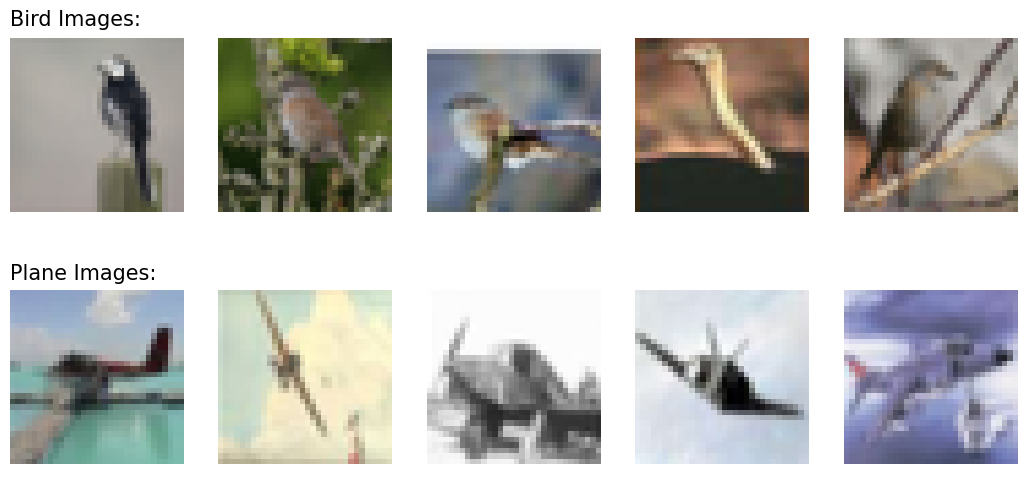

In [13]:
def de_normalise_image(image):
    return(image*0.5 + 0.5)

fig = plt.figure(figsize=(13,6))

gs = fig.add_gridspec(2,5) #2 rows, 5 columns for the images

for i in range(5):
    # First row
    ax1 = fig.add_subplot(gs[0, i])
    ax1.axis('off')
    ax1.imshow(de_normalise_image(images[rand_bird_indices[i]].transpose((1, 2, 0))))
    
    # Second row, directly below the first row
    ax2 = fig.add_subplot(gs[1, i])
    ax2.axis('off')
    ax2.imshow(de_normalise_image(images[rand_plane_indices[i]].transpose((1, 2, 0))))


ax_text = fig.add_subplot()
ax_text.axis('off')  # Hide the axes
ax_text.text(0, 1, 'Bird Images:', horizontalalignment='left', verticalalignment='center', transform=ax_text.transAxes, fontsize=15)
ax_text = fig.add_subplot()
ax_text.axis('off')  # Hide the axes
ax_text.text(0, 0.45, 'Plane Images:', horizontalalignment='left', verticalalignment='center', transform=ax_text.transAxes, fontsize=15)

plt.show()


We can also observe the pixel intensity distribution of our images. This will verify if we have correctly normalised the data, while also giving us some insight into what said data looks like.

<function matplotlib.pyplot.show(close=None, block=None)>

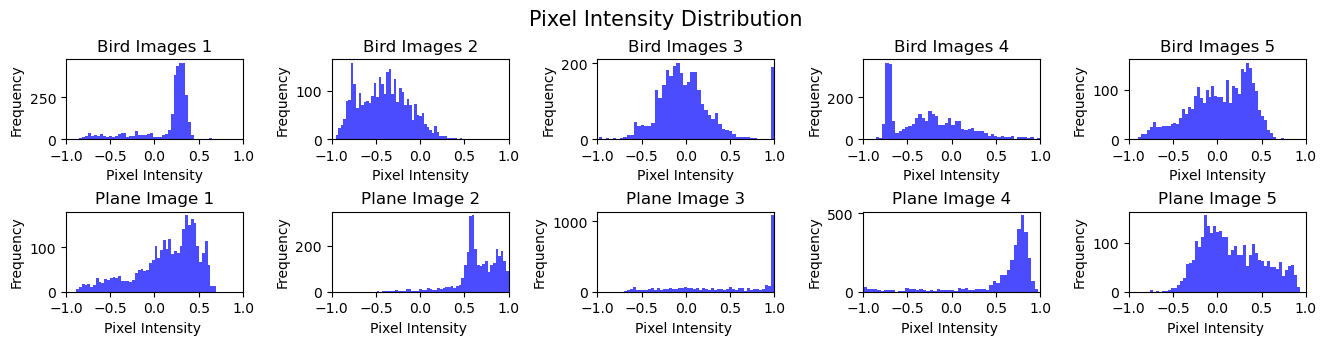

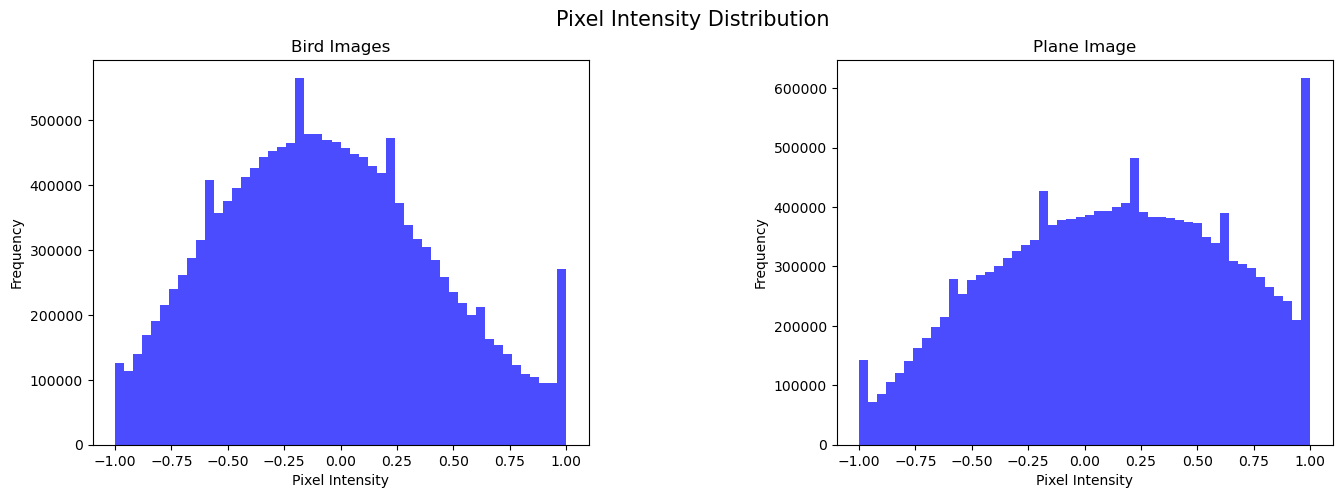

In [14]:
#Histograms of random images
fig1 = plt.figure(figsize=(16,5))

gs = fig1.add_gridspec(3,5)

for i in range(5):
     
    ax1 = fig1.add_subplot(gs[0, i])
    ax1.hist(images[rand_bird_indices[i]].flatten(), bins=50, color='blue', alpha=0.7)
    ax1.set_xlabel('Pixel Intensity')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Bird Images {i+1}')
    ax1.set_xlim([-1, 1])  # Not all images reach both ends of the pixel intensity spectrum, I have extended the axis to the minimums and maximums possible for consistency in images

    ax2 = fig1.add_subplot(gs[1, i])
    ax2.hist(images[rand_plane_indices[i]].flatten(), bins=50, color='blue', alpha=0.7)
    ax2.set_xlabel('Pixel Intensity ')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Plane Image {i+1}')
    ax2.set_xlim([-1, 1])  


fig1.suptitle('Pixel Intensity Distribution', fontsize=15)


plt.subplots_adjust(wspace=0.5, hspace=0.9) # Change the values as needed
plt.show


# Total histogram for each set
fig1 = plt.figure(figsize=(16,5))

gs = fig1.add_gridspec(1,2)

ax1 = fig1.add_subplot(gs[0, 0])
ax1.hist(bird_images.flatten(), bins=50, color='blue', alpha=0.7)
ax1.set_title('Bird Images')
ax1.set_xlabel('Pixel Intensity')
ax1.set_ylabel('Frequency')

ax2 = fig1.add_subplot(gs[0, 1])
ax2.hist(plane_images.flatten(), bins=50, color='blue', alpha=0.7)
test = 12
ax2.set_title('Plane Image')
ax2.set_xlabel('Pixel Intensity')
ax2.set_ylabel('Frequency')
    
fig1.suptitle('Pixel Intensity Distribution', fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5) # Change the values as needed
plt.show

From our individual images, we can see that there is a significant amount of variation from image to image, indicating high diversity and potentially leading to challenging classification. This is because birds and planes vary greatly between species/models, along with possible differences in lighting, backgrounds etc. We can however see, that the overall distributions do vary from set to set, with a a wider range of colours in the plane images, yet a higher peak of certain colours in the bird images. The differences between these distributions tell us that the model may be able to use this as a feature to distinguish the bird and plane images from each other.\
\
The second set of graphs also falls within the range of [-1, 1] so we can be sure that our normalisation to this range has been successful. While the distribution here is relatively uniform for each set, we can see outliers in certain pixel intensities, in particular 1. This is the normalised value of white (originally 255) and represents real-world images that the model could recieve as getting pictures of birds/planes with a heavy white prescence (i.e. flying with clouds in the background). This variety should help our model recognise birds and planes under a range of conditions, not necessarily ideal ones. 

### Creating dataloaders

Next we must create dataloaders, so we can have an iterable over our dataset:

In [15]:
trainloader = DataLoader(trainset_filtered, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset_filtered, batch_size=64, shuffle=False, num_workers=4)

We should also have class labels for our invididual classes to be distinguished. In this case, it is 'bird' and 'airplane' which can be configured as follows:

In [16]:
classes = {'bird', 'airplane'}

We shuffle the data in our training dataset. This is to make sure that the model doesn't learn anything from the order of images input. This isn't necessary with our testing dataset however, so we can leave this false. 
Num_workers relates to the number seperate workers that will load the data in parallel. While a high number of workers may speed up performance, it may also increase memory utilisation so its good to strike a balance.
We are also using a batch size of 4. A larger batch size can be good for speed, but too high and we risk lower accuracy and overfitting.

## Defining and Training a Simple Model

For image classification tasks, standard neural networks don't scale well as image size increases, and aren't very accurate. [SOURCE: https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/]. As such, we will be using a CNN to classify our images. We can begin by constructing a SimpleCNN for image classification, and to do that we need to know the structure of CNNs. Like most deep neural networks, we must initialise the layers, which we can do with the '__init__' function. We must also use the forwards function to define the forward pass of the network, which is what takes an input and returns an output from the model.[SOURCE:  https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/ <- Same as before]\
In this model we will be using the following layers:

>  The convolutional layer. In this layer a set of filters is applied to the input, with the goal of extracting meaningful patterns or features of the data. It has properties such as the kernel size which denotes the size of the convolutional filter applied and the stride which relates to how many pixels said filter moves across the input image at a time. It also has in_channels which indicates how many feature map inputs it takes, and an out_channel for the output. To know the size of our convolutional layer we can use the following formula -> Output size of convolution = [(width/height of image) - (size of kernel)] / (stride) + 1. E.g., 32-5/1 + 1 = 28. \
> The pooling layer. In this layer the dimensions of an image are reduced, which in turn leads to fewer parameters. It aims to condense the information, thus reducing the amount of computation that the network performs. It also has a kernel size and stride like the convolutional layer. \
> The fully connected layer. As the name suggests, all neurons in a fully connected layer, are fully connected to all activations in the previous layer. In CNNs thjese layers often comes after convolutional and pooling layers. The amount of neurons is determined by the amount of outputs, with each neuron consisting of a weight and a bias. [SOURCE: https://www.geeksforgeeks.org/activation-functions-neural-networks/]

We also need to consider the 'forward' function, which is where we actually walk through the network, taking out images as inputs and returning a 0-1 probability as an output. In our case, 1 indicates bird an 0 indicates airplane, so if an output returns 0.55 the nextwork predicts a 55% chance of the image being a bird. When designing the forward feed network, we must also consider the activation functions, on top of the layers it's running through. The purpose of an activation function is to introduce non-linearity into the outputs of our neurons, as in the real world data is rarely linear and cannot be accurately modelled by a straight line. To do this it decides whether or not the neuron should be activated based on the weighted sum and bias. In our case, we will use the popular 'RELU' and 'Sigmoid' activation functions
> The RELU function is very simple, and performs the operation max(0,x), giving us the output x if positive, and 0 otherwise. Due to its simplistic nature, this function has the benefit of being less computationally expensive than other activation functions and by extension, it results in efficient and easy computation.\
> The Sigmoid function is slightly more complex than RELU, though still not too complicated. It performs the operation 1/(1 + e<sup>-x</sup>) and results in an S shaped graph.

We can see how a feature map size is determined with a stride of 2, hence 2 steps at a time, below [SOURCE: https://miro.medium.com/v2/resize:fit:1400/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif]: \
![Feature map.](https://miro.medium.com/v2/resize:fit:1400/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif) 

### Defining a Simple CNN Architecture

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer takes 3 input channels (for RGB images), produces 6 output channels, and uses a 5x5 kernel for convolution.
        # Since each image is 32x32 pixels with 3 channels for RGB, applying 5x5 kernel with 1 stride = 28x28 output (32-5/1 + 1 = 28), so 6 channels with 28x28 output each.
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1,padding=0) 
        # Max Pooling layer with a 2x2 kernel and a stride of 2. This will reduce the spatial dimensions of the output from the first convolutional layer by half.
        # Turning 6 output channels of 28x28 into 6 output channels of 14x14.
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2) #28/2 -> 14 for both height and width
        # The convolutional and max pooling layer have reduced the dimensions of the input images from 3 channels of 32x32 to 6 channels of 14x14
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=(14 * 14 * 6),out_features=1) # height * width * channels -> 14 * 14 * 6
    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 14*14*6)  # Flatten the tensor before feeding it into fc1
        
        x = torch.sigmoid(self.fc1(x)) # Apply sigmoid activation to the output layer for binary classification
        x = torch.squeeze(x) #Squeezes the torch to our desired output size

        return x

Simple_CNN = SimpleCNN().to(device) #Offloads SimpleCNN to GPU if available
Simple_CNN

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1176, out_features=1, bias=True)
)

### Defining Loss Function and Optimizer

The loss function is what we use to calculate the error, quantifying the difference between the predicted output and the actual output. It helps us measure the performance of a model, while also indicating the direction to improve in. For general image classification, you will likely want to use Cross-Entropy classification, however in our case as we only have 2 sets of images, we can use Binary Cross-Entropy: 
$$
L_{BCE} = -\frac{1}{n} \sum_{i=1}^{n} \left(t_i \cdot log(\hat{t}_i) + (1 - t_i) \cdot log(1 - \hat{t}_i)\right)
$$
This formula shows us the Binary Cross Entropy loss across all data samples, giving us the total sum. In this formula, 'N' represents all data points and 't' is the truth value, i.e. the actual label, while 'p' is our predicted probability given by the model, that a particular datapoint has a label of 1.  To break it down we can take an example of a single data point and explain it as follows. \
This data point has the label of 1, so is classified as 1. Reducing this formula to an individual data point, we can see that the loss is calculated as a function of the probability our model has assigned to the label being 1 or 0 and of the actual label. For example, if the actual label is 1, the function becomes:
$$
l = -(1*log(p) + (1-1)log(1-p)) = -(1*log(p))
$$
In this situation, the loss grows as P deviates from 1, indicating that the model is penalised for assigning a probability that differs from the ground truth. By aggregating this loss over an entire batch, using the first formula, we can find the average loss which can then be used to update the models probability and optimise the loss.
[SOURCE: https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning]

Next we must define an optimiser for our model. The role of an optimiser is to find the optimal model parameters. We will initialise it with a learning rate of 0.01 fairly standard learning rate of 0.01. If the learning rate is too high it can overshoot the solution, whereas if it is too low it can take too long to train, while also getting stuck in a local minimum. We will be using the ADAM optimiser, which naturally adjusts the learning rate to efficiently navigate the landscape during training, leading to faster convergence and improved network performance. [Source: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=An%20optimizer%20is%20a%20function,overall%20loss%20and%20improving%20accuracy.]. There are many different available optimisers though, so you can choose whatever serves your purpose better.

In [18]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(Simple_CNN.parameters(), lr = 0.001)

### Training the Model

We now have our basic model, and must train it. When training our dataset we must consider how many 'epochs' we want. An epoch in machine learning is definied as one complete pass of the training dataset, and in very large datasets you may be able to use 1 epoch (or even less) resulting in 1 loop over the data. As we use more epochs while training, our training data should get closer to the expected output, however using too many epochs can cause overfitting. This is where the model learns the training data too well, and can perform well on this data but poorly on new, unseen data. We will use 20 epochs as it is more than sufficient for this task, without overtraining it, though you can set this number to what you want.

In [19]:
num_epochs = 20

Now we want to define our training loop. This is where we essentially feed the model our data for every epoch through the forward function of our model, and based on our output (the prediction on the data), the weights and biases of our model are adjusted using backpropagation To do this we can start by initialising an array to keep track of our loss over time, before defining a loop for all of our epochs. Within this loop we can initialise an integer to keep track of our loss over our current epoch. We can then iterate over the trainloader dataset, and begin training for each datapoint. In here we first move the data to our cuda enabled GPU, if available, as it speeds up training times. We must also zero the gradients on our optimiser to prevent using stale gradients from previous batches, that are no longer relevant to us. Next we can feed our current data point to our Simple_CNN, where it will perform the 'forward' function and return an output which is essentially a prediction. Using this output prediction, we want to calculate the BCE loss between the outputs and true labels. We can now backpropagate through the network using the 'backward' function provided by PyTorch, which calculates the gradient of loss with respect to all our model parameters. Finally, we can use the 'step' function of the optimizer to update our model parameters (weights and biases) in an aim to minimise loss. You can optionally add increment our running_loss if you want to keep track of it, as we have done so here.

In [20]:
def train_model(cnn, dataloader, loss_fn, optimizer, total_loss):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs, labels = data
            if(torch.cuda.is_available()):
                inputs, labels = inputs.cuda(), labels.cuda() 
            labels = labels.float()

            #zero the gradients
            optimizer.zero_grad()

            #input data to model
            outputs = cnn(inputs)

            #Calculates binary cross entropy loss
            loss = loss_fn(outputs, labels)
            #Calculates gradient of the loss with respect to all model parameters
            loss.backward()

            #Optimizer update model parameters (weights and biases) in order to minimise loss
            optimizer.step()
            running_loss += loss.item()
        loss_per_epoch = running_loss/len(trainloader)
        total_loss.append(loss_per_epoch)
        print(f"Average loss over epoch {epoch+1}: {round(loss_per_epoch, 3)}")    

Now that we have defined our training loop, we want to run it.

In [21]:
simple_total_loss = [] #Counts loss
start_time = time.time() #Get the time at the beginning of the training loop

train_model(cnn=Simple_CNN, dataloader=trainloader, loss_fn=loss_fn, optimizer=optimizer,total_loss=simple_total_loss)


simple_training_time = time.time() - start_time
print(f"Training runtime: {simple_training_time} seconds")

Average loss over epoch 1: 0.497
Average loss over epoch 2: 0.398
Average loss over epoch 3: 0.37
Average loss over epoch 4: 0.355
Average loss over epoch 5: 0.344
Average loss over epoch 6: 0.339
Average loss over epoch 7: 0.337
Average loss over epoch 8: 0.329
Average loss over epoch 9: 0.324
Average loss over epoch 10: 0.317
Average loss over epoch 11: 0.312
Average loss over epoch 12: 0.309
Average loss over epoch 13: 0.303
Average loss over epoch 14: 0.3
Average loss over epoch 15: 0.294
Average loss over epoch 16: 0.293
Average loss over epoch 17: 0.29
Average loss over epoch 18: 0.286
Average loss over epoch 19: 0.283
Average loss over epoch 20: 0.281
Training runtime: 248.33140206336975 seconds


We can now visualise how our network performed over the course of our epochs, using the total loss calculated in previous steps.

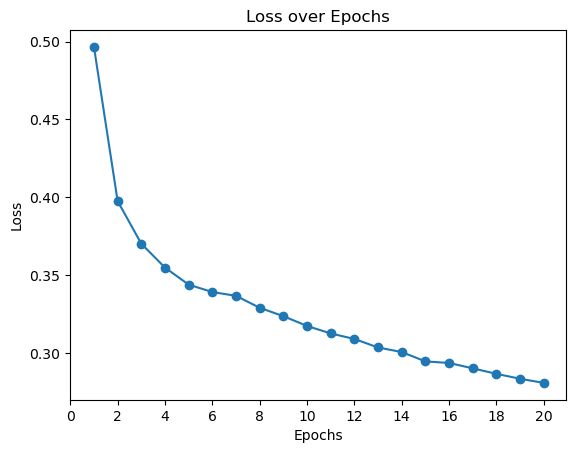

In [22]:
plt.plot(range(1,num_epochs+1), simple_total_loss, marker="o", linestyle="-")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(0,num_epochs+1,2))
plt.show()

As we can see, when our training started, our average loss was close to 0.5, which makes sense as the network was predicting values without knowledge of the network, essentially making random guesses. Over the course of each epoch, and through training, this loss was greatly reduced, to around 0.27. This loss value is still relatively high and can definitely be optimised with a better model.

### Evaluating the Model

Next we can check the accuracy of our model using our test set to check how well it works on new, fresh data.

In [69]:
def compare_accuracy(model, dataloader):
    if(torch.cuda.is_available()):
        model.cuda()
    total = 0
    correct = 0
    for data in dataloader:
        (inputs, labels) = data
        if(torch.cuda.is_available()):
             inputs, labels = inputs.cuda(), labels.cuda() 
        labels = labels.float() 
        outputs = model(inputs) #Run batch through model and recieve outputs
        predicted = outputs >= 0.5 #If probability >= 0.5, predict it as a bird. Otherwise predict it as a plane.
        total += labels.size(0)
        correct += (predicted.float() == labels).sum().item() #Check which predictions match the labels, and increment correct for every correct prediction
    return 100*correct/total

simple_accuracy_train = compare_accuracy(Simple_CNN, trainloader)
simple_accuracy_test = compare_accuracy(Simple_CNN, testloader)

print(f"Accuracy on Training Set: {simple_accuracy_train}%") #Calculate the accuracy by dividing correct predictions, by total predictions
print(f"Accuracy on Test Set: {simple_accuracy_test}%") #Calculate the accuracy by dividing correct predictions, by total predictions

Accuracy on Training Set: 88.81%
Accuracy on Test Set: 86.9%


As we can see, our we have a slightly higher accuracy on our training set, indicating a small amount of overfitting, but otherwise we have a relatively accuracy model considering the size of the network. We should be able to improve this with a more complex model, which we can attempt to create.

## More Complex Model

Now we can construct a more complex model based on our previous model to try and achieve a better accuracy. To do this, we have increased the amount of layers being used, along with changing the properties of pre-existing layers in order to optimise our model. We have also added 2 new layers to this model, in an attempt to improve the accuracy:
> The dropout layer. This layer provides a probability which determines whether a node will be dropped out in an attempt to negate overfitting. I have provided them here with a 35% probability. \
> The batch normalisation layer. The batch normalisation normalises inputs from the previous layer, standardising the input which improves mitigate the problem of vanishing or exploding gradients.

In [25]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        # 3 input channels (RGB), 16 outputs, 5x5 convolution 
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1) 
        self.batch1 = nn.BatchNorm2d(32) #Batch norm layer doesn't change size of tensor
        self.conv2 = nn.Conv2d(32,64,3,1,1)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64,128,3,1,1)
        self.batch3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*8*8, 256) 
        self.dropout1 = nn.Dropout(p = 0.35) 
        self.fc2 = nn.Linear(256, 128) 
        self.dropout2 = nn.Dropout(p = 0.35)
        
        self.fc3 = nn.Linear(128,1) # 1 output, for binary classification (Bird or Airplane).

    #Conduct forward pass on model    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = self.pool2(x)
        x = torch.flatten(x,1) # Total number of elements in tensor
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x)) # Apply sigmoid activation to the output layer for binary classification
        x = torch.squeeze(x) #Squeezes the torch to our desired output size
        #print(x)
        return x


Complex_CNN = ComplexCNN().to(device) 
Complex_CNN



ComplexCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

We can now train the model using the same function we defined for the simple CNN.

In [27]:
complex_total_loss = [] #Counts loss
start_time = time.time() #Get the time at the beginning of the training loop
train_model(cnn=Complex_CNN, dataloader=trainloader, loss_fn=loss_fn, optimizer=optimizer,total_loss=complex_total_loss)
complex_training_time = time.time() - start_time
print(f"Training runtime: {complex_training_time} seconds")

Average loss over epoch 1: 0.385
Average loss over epoch 2: 0.289
Average loss over epoch 3: 0.239
Average loss over epoch 4: 0.195
Average loss over epoch 5: 0.154
Average loss over epoch 6: 0.126
Average loss over epoch 7: 0.096
Average loss over epoch 8: 0.076
Average loss over epoch 9: 0.054
Average loss over epoch 10: 0.062
Average loss over epoch 11: 0.039
Average loss over epoch 12: 0.037
Average loss over epoch 13: 0.036
Average loss over epoch 14: 0.031
Average loss over epoch 15: 0.023
Average loss over epoch 16: 0.021
Average loss over epoch 17: 0.023
Average loss over epoch 18: 0.021
Average loss over epoch 19: 0.017
Average loss over epoch 20: 0.015
Training runtime: 254.5003798007965 seconds


The training time of our new, complex model is only 6 seconds slower than our simple model, despite being a lot more complicated. This is because we are bottlenecked iterating over our trainloader and our GPU is running the model fast enough to make the time difference nearly neglibile. These results amy however vary on different hardware.

### Evaluating the Model

We can now evaluate the accuracy of our new Complex model and check for overfitting like we did in our simple model.

In [71]:
complex_accuracy_train = compare_accuracy(Complex_CNN, trainloader)
complex_accuracy_test = compare_accuracy(Complex_CNN, testloader)

print(f"Accuracy on Training Set: {complex_accuracy_train}%    Improvement over Simple Model: {complex_accuracy_train-simple_accuracy_train:.2f}%") #Calculate the accuracy by dividing correct predictions, by total predictions
print(f"Accuracy on Test Set: {complex_accuracy_test}%    Improvement over Simple Model: {complex_accuracy_test-simple_accuracy_test:.2f}%") #Calculate the accuracy by dividing correct predictions, by total predictions


Accuracy on Training Set: 99.78%    Improvement over Simple Model: 10.97%
Accuracy on Test Set: 92.2%    Improvement over Simple Model: 5.30%


The accuracy of this new complex model is better than our simple model by a fair margin on the testing set, but it is leagues ahead on the training set. While this models performance is good, the training set accuracy indicates moderate overfitting has occured and may be possible to somewhat correct with tweaking, though over the course of tweaking values this was the best performance I was able to obtain.

We can also view the loss of our new complex model across epochs and compare it to out simple model


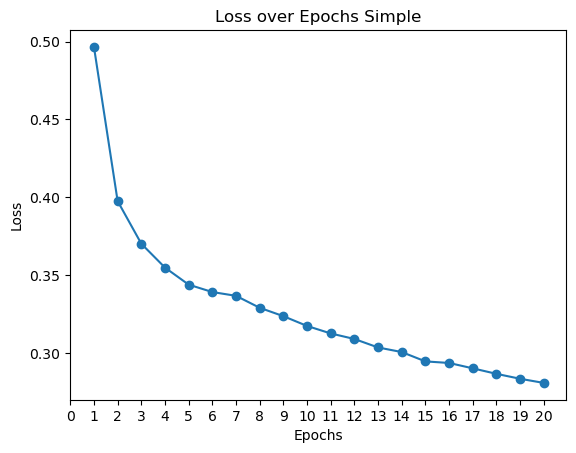

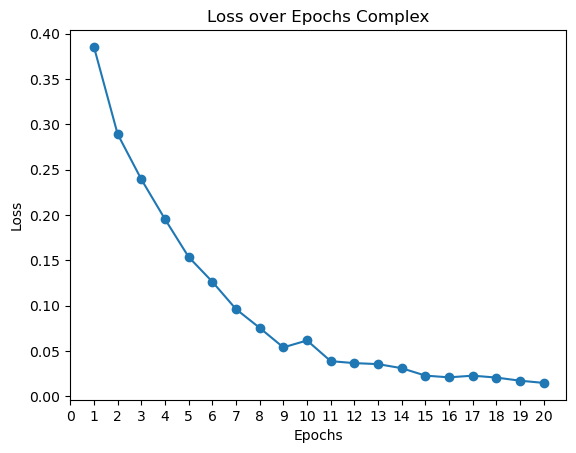

In [58]:
plt.plot(range(1, num_epochs + 1), simple_total_loss, marker="o", linestyle="-")
plt.title("Loss over Epochs - Simple Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(0,num_epochs + 1))
plt.ylim(0.5, 0)  
plt.show()

plt.plot(range(1, num_epochs + 1), complex_total_loss, marker="o", linestyle="-")
plt.title("Loss over Epochs - Complex Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(0,num_epochs+1))
plt.ylim(0.5, 0)
plt.show()

In our more complex model, we can see that the loss per epoch on both graphs follow a similar trend, however we end with a far lower loss in our complex model which indicates a more optimal, reliable model.

To compare both our previous models, we will sample 5 random images from the dataset, and compare the accuracy of predictions from either model.

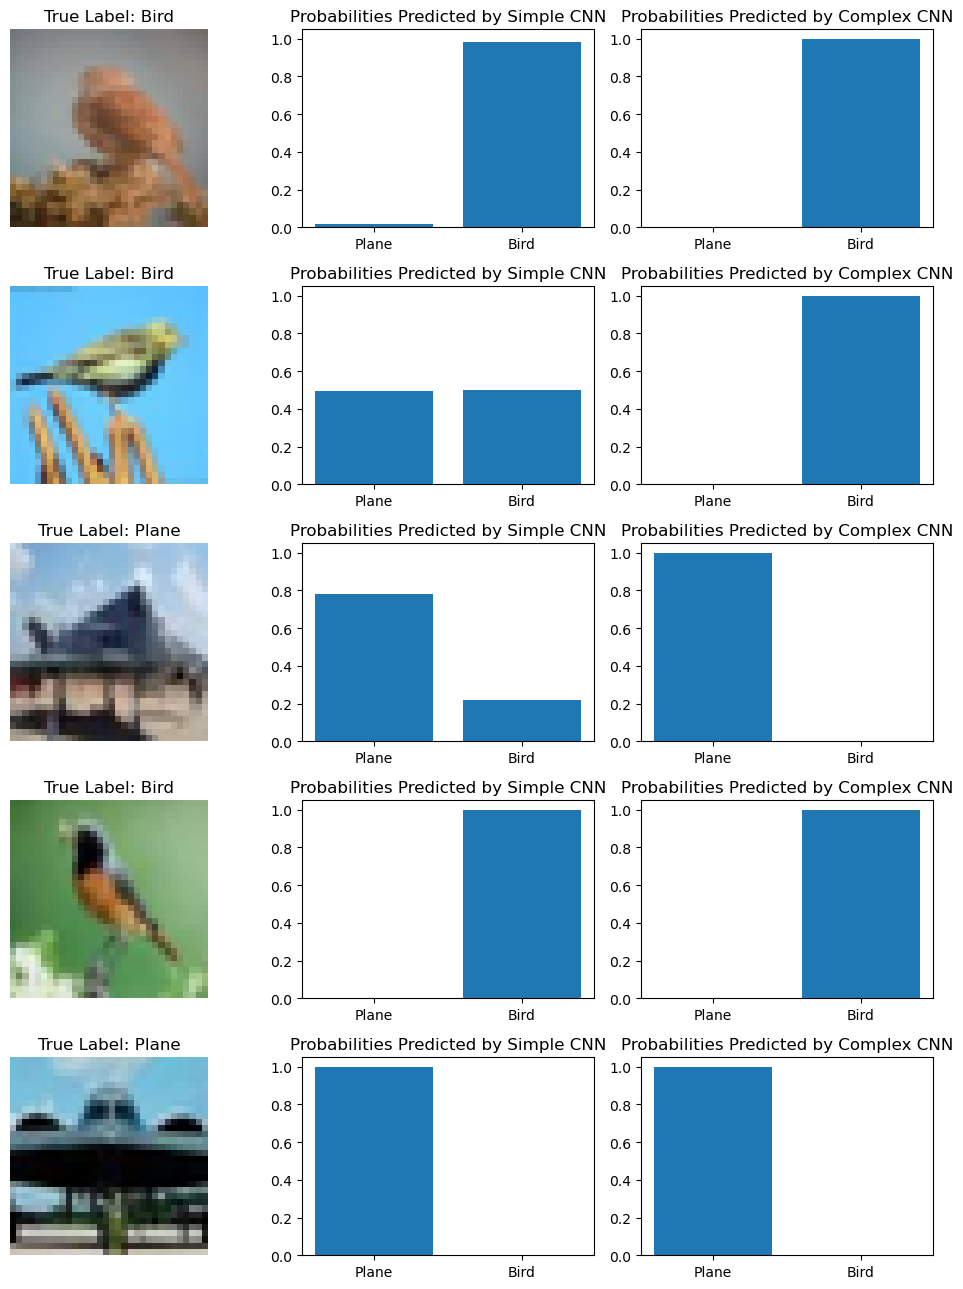

In [74]:
dataiter = iter(testloader)
images, labels = next(dataiter)
indices = np.random.choice(np.arange(len(images)), 5, replace=False)
images, labels = images[indices], labels[indices]
Simple_CNN = Simple_CNN.cpu() #Move back to CPU if on GPU
Complex_CNN = Complex_CNN.cpu()
Simple_CNN.eval()
Complex_CNN.eval()
with torch.no_grad():
    simple_outputs = Simple_CNN(images)
    complex_outputs = Complex_CNN(images)


fig, axes = plt.subplots(5, 3, figsize=(10, 13))  # Adjusted for 5 images, each with 2 subplots

for i, (image, label, simple_probability, complex_probability) in enumerate(zip(images, labels, simple_outputs, complex_outputs)):
    image = image / 2 + 0.5
    npimage = image.numpy()
    axes[i, 0].imshow(np.transpose(npimage, (1, 2, 0)))  # Directly show the image in the subplot
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'True Label: {"Bird" if label.item()==1 else "Plane"}')
    
    axes[i, 1].bar(['Plane', 'Bird'], [1-simple_probability.item(), simple_probability.item()])
    axes[i, 1].set_ylim(0, 1.05)
    axes[i, 1].set_title('Probabilities Predicted by Simple CNN')

    axes[i, 2].bar(['Plane', 'Bird'], [1-complex_probability.item(), complex_probability.item()])
    axes[i, 2].set_ylim(0, 1.05)
    axes[i, 2].set_title('Probabilities Predicted by Complex CNN')

plt.tight_layout()
plt.show()

Here you can see that the complex model is often more certain with its predictions than the Simple CNN, sometimes to a fairly substantial degree. From this evidence, and the raw numbers we have seen earlier, we can conclude that the complex model does a better job at classifying images than the simpler model, and is likely worth the extra computational time.

### Hyperparameter Tuning Results

Todo: Describe hyperparameter tuning results:

Learning rate, epochs, momentum, layers, kernel size, padding, stride

## Building a GAN 

Now we will define a GAN model to generate pictures of birds. GAN standards for 'Generative Adversial Network' and has 2 main components: the generator and the discriminator.
The purpose of the generator is to, you guessed it, generate images. It does this by communicating with the discriminator which tries to determine if the images are real or fake.
TODO Expand on this

In [60]:
trainset_filtered_birds = Subset(trainset_filtered, bird_indices)
bird_trainloader = DataLoader(trainset_filtered_birds, batch_size=64, shuffle=False, num_workers=4)
print(len(trainset_filtered_birds))

5000


### Defining the Generator Model

In [61]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # output size=stride×(input size−1)+kernel size−2×padding+output padding
        # Input is size of noise vector, reshaped to 1x1 spatial dimension
        self.tconv1 = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(512)
        # Output size: (512, 4, 4)
        self.tconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(256)
        # Output size: (256, 8, 8)
        self.tconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(128)
        # Output size: (128, 16, 16)
        self.tconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm4 = nn.BatchNorm2d(64)
        # Output size: (64, 32, 32)
        self.tconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
        # Final output size: (3, 32, 32) matching RGB image of 32x32 pixels

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.tconv1(x)))
        x = F.relu(self.batchnorm2(self.tconv2(x)))
        x = F.relu(self.batchnorm3(self.tconv3(x)))
        x = F.relu(self.batchnorm4(self.tconv4(x)))
        x = torch.tanh(self.tconv5(x))
        return x

generator = Generator().to(device)
generator

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

### Defining the Discriminator Model

Next we must define the discriminator model. We will utilise the structure of our previous Complex Neural Network for convienence, and it has proven utility in Binary Image Classification already, but you can structure it differently as you see fit.

In [62]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1) #32-3+2/1 + 1 = 32
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3,1,1)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*16*16, 256)
        self.dropout1 = nn.Dropout(p = 0.35) 
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p = 0.35)
        self.fc3 = nn.Linear(128,1)     

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool1(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.squeeze(x) 
        return x
discriminator = Discriminator().to(device)
discriminator

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

### Training the GAN

TODO: Describe training process

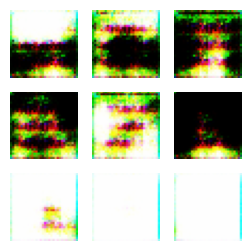

Epoch 1/200
Discriminator Loss: 0.3621605336666107
Generator Loss: 4.8104352951049805
Discriminator Confidence (Real): 0.9111026525497437
Discriminator Confidence (Fake): Before Generator Update: 0.1976490169763565, After Generator Update: 0.03968231379985809



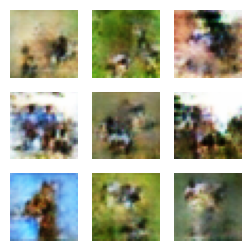

Epoch 40/200
Discriminator Loss: 0.017588049173355103
Generator Loss: 8.598199844360352
Discriminator Confidence (Real): 0.9985448122024536
Discriminator Confidence (Fake): Before Generator Update: 0.01586425118148327, After Generator Update: 0.0010990618029609323



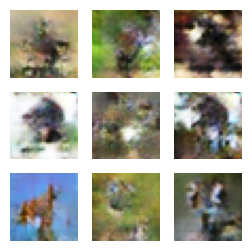

Epoch 80/200
Discriminator Loss: 0.009176574647426605
Generator Loss: 8.966572761535645
Discriminator Confidence (Real): 0.9993304014205933
Discriminator Confidence (Fake): Before Generator Update: 0.00838514044880867, After Generator Update: 0.026539385318756104



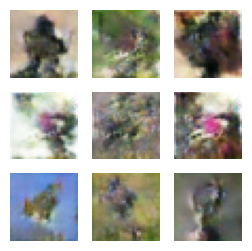

Epoch 120/200
Discriminator Loss: 0.006035126745700836
Generator Loss: 6.777439117431641
Discriminator Confidence (Real): 0.9999542236328125
Discriminator Confidence (Fake): Before Generator Update: 0.005890063941478729, After Generator Update: 0.0018567638471722603



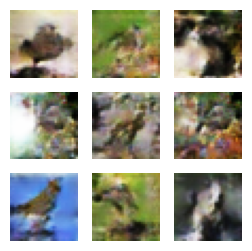

Epoch 160/200
Discriminator Loss: 0.003375279949977994
Generator Loss: 6.791077613830566
Discriminator Confidence (Real): 0.9998350739479065
Discriminator Confidence (Fake): Before Generator Update: 0.0031898003071546555, After Generator Update: 0.003270206041634083



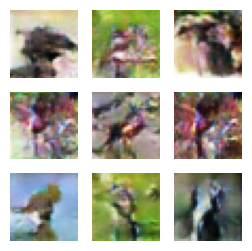

Epoch 200/200
Discriminator Loss: 0.0005442899418994784
Generator Loss: 10.044229507446289
Discriminator Confidence (Real): 0.9999898672103882
Discriminator Confidence (Fake): Before Generator Update: 0.0005334862507879734, After Generator Update: 0.00018057455599773675

Training runtime: 2721.6381306648254 seconds


In [64]:
loss_fn = nn.BCELoss()
gan_num_epochs = 200
generator_optimizer = optim.Adam(generator.parameters(), lr = 0.0001, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0001, betas=(0.5, 0.999))
fake_label = 0
real_label = 1
loss_disc_values = []
loss_gen_values = []
disc_confidence_values = [] #Confidence in prediction
disc_gen_confidence_before_values = [] #Tracks 
disc_gen_confidence_after_values = [] #
images = []
start_time = time.time()

test_noise_vector = torch.randn(64, 100, 1, 1,device=device)
for epoch in range(gan_num_epochs):
    for data in bird_trainloader:
        # Start with discriminator
        real_data = data[0].to(device)
        batch_size_image = real_data.size(0)
        discriminator.zero_grad()
        images_and_labels = torch.full((batch_size_image,),real_label,dtype=torch.float, device=device) #Load images with labels into tensor
        outputs = discriminator(real_data).view(-1) #Run the real data through the discriminator
        real_discrimiator_loss = loss_fn(outputs, images_and_labels) #Get the loss of the discriminator on real data
        real_discrimiator_loss.backward()
        disc_confidence = outputs.mean().item()

        noise = torch.randn(batch_size_image,100,1,1,device=device) #Generate random noise vectors of the same batch size as our real_data, with 100 size
        fake_images = generator(noise) #Input noise vector into generator model, doesn't need 0 grad for noise vector
        images_and_labels.fill_(fake_label)
        outputs = discriminator(fake_images.detach()).view(-1) #Run the fake data through the discriminator
        fake_discrimiator_loss = loss_fn(outputs, images_and_labels)
        fake_discrimiator_loss.backward()
        disc_gen_confidence_before = outputs.mean().item()
        discriminator_optimizer.step()

        generator.zero_grad()
        images_and_labels.fill_(real_label)
        outputs = discriminator(fake_images).view(-1)
        generator_loss = loss_fn(outputs, images_and_labels)
        generator_loss.backward()
        disc_gen_confidence_after = outputs.mean().item()
        discriminator_loss = real_discrimiator_loss + fake_discrimiator_loss
        generator_optimizer.step()
        
        loss_disc_values.append((real_discrimiator_loss + fake_discrimiator_loss).item())
        loss_gen_values.append(generator_loss.item())
        disc_confidence_values.append(disc_confidence)
        disc_gen_confidence_before_values.append(disc_gen_confidence_before)
        disc_gen_confidence_after_values.append(disc_gen_confidence_after)
    with torch.no_grad():
        fake = generator(test_noise_vector).detach().cpu()
        
    images.append(utils.make_grid(fake, padding=2, normalize=True))
    if(((epoch+1)%40 == 0) or (epoch == 0)): #Print images and loss after every 40 epochs
        fake_image_visualised = (fake + 1) / 2 
        fake_image_visualised = np.transpose(fake_image_visualised.numpy(), (0, 2, 3, 1))
        plt.figure(figsize=(3,3))
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(fake_image_visualised[i].squeeze())
            plt.axis('off')
        plt.show()
        print(f'Epoch {epoch+1}/{gan_num_epochs}\nDiscriminator Loss: {discriminator_loss.item()}\nGenerator Loss: {generator_loss}\nDiscriminator Confidence (Real): {disc_confidence}\nDiscriminator Confidence (Fake): Before Generator Update: {disc_gen_confidence_before}, After Generator Update: {disc_gen_confidence_after}\n') 
            
          
gan_training_time = time.time() - start_time
print(f"Training runtime: {gan_training_time} seconds")


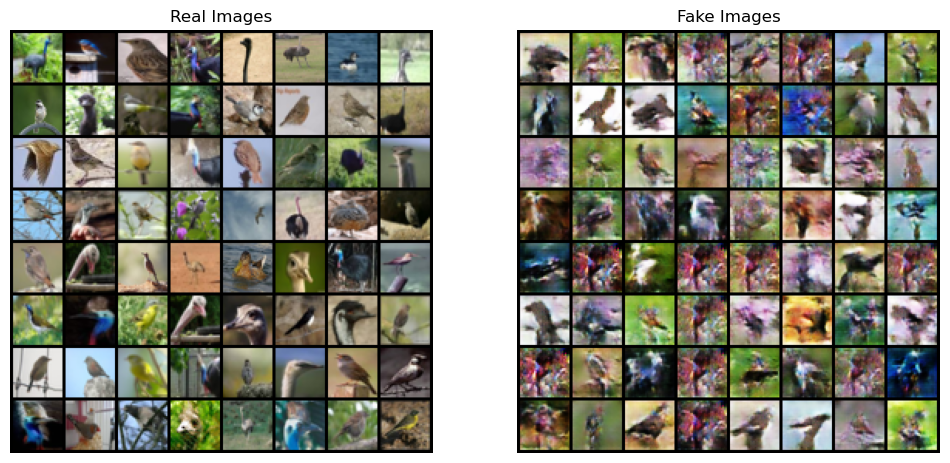

In [65]:
batch = next(iter(bird_trainloader))
 
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(batch[0][:64], normalize=True),(1,2,0))) #We can set normalize=True to de-normalise the images automatically
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(images[-1], (1, 2, 0)))
plt.show()